# This notebook contains Portfolio optimizations of randomized tech stocks using Monte Carlo simulation of portfolio dstributions
## Sharpe ratios are used as risk adjusted return metric and Markowitz to calculate the Efficient Frontier

In [108]:
import numpy as np 
import pandas as pd 
import quandl
import matplotlib.pyplot as plt
%matplotlib inline

In [109]:
start = pd.to_datetime('2012-01-01')
end = pd.to_datetime('2018-06-01')

In [110]:
aapl = quandl.get('WIKI/AAPL.11',start_date=start,end_date=end, index_col='Date', parse_dates=True)
csco = quandl.get('WIKI/CSCO.11',start_date=start,end_date=end, index_col='Date', parse_dates=True)
ibm = quandl.get('WIKI/IBM.11',start_date=start,end_date=end, index_col='Date', parse_dates=True)
amzn = quandl.get('WIKI/AMZN.11',start_date=start,end_date=end, index_col='Date', parse_dates=True)

In [111]:
stocks = pd.concat([aapl,csco,ibm,amzn],axis =1)
stocks.columns = ['AAPL','CSCO','IBM','AMZN']

In [112]:
stocks.head()

,AAPL,CSCO,IBM,AMZN
Date,,,,
2012-01-03,52.848787,15.617341,157.578371,179.03
2012-01-04,53.132802,15.919125,156.935540,177.51
2012-01-05,53.722681,15.860445,156.191208,177.61
2012-01-06,54.284287,15.801764,154.398046,182.61
2012-01-09,54.198183,15.902359,153.594506,178.56


In [113]:
stocks.pct_change(1).mean()

AAPL    0.000864
CSCO    0.000738
IBM     0.000045
AMZN    0.001528
dtype: float64

In [114]:
stocks.pct_change(1).corr()

,AAPL,CSCO,IBM,AMZN
AAPL,1.000000,0.317531,0.285458,0.268870
CSCO,0.317531,1.000000,0.418203,0.289248
IBM,0.285458,0.418203,1.000000,0.246818
AMZN,0.268870,0.289248,0.246818,1.000000


In [115]:
log_ret = np.log(stocks/stocks.shift(1))
log_ret.head()

,AAPL,CSCO,IBM,AMZN
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005360,0.019139,-0.004088,-0.008526
2012-01-05,0.011041,-0.003693,-0.004754,0.000563
2012-01-06,0.010400,-0.003707,-0.011547,0.027763
2012-01-09,-0.001587,0.006346,-0.005218,-0.022428


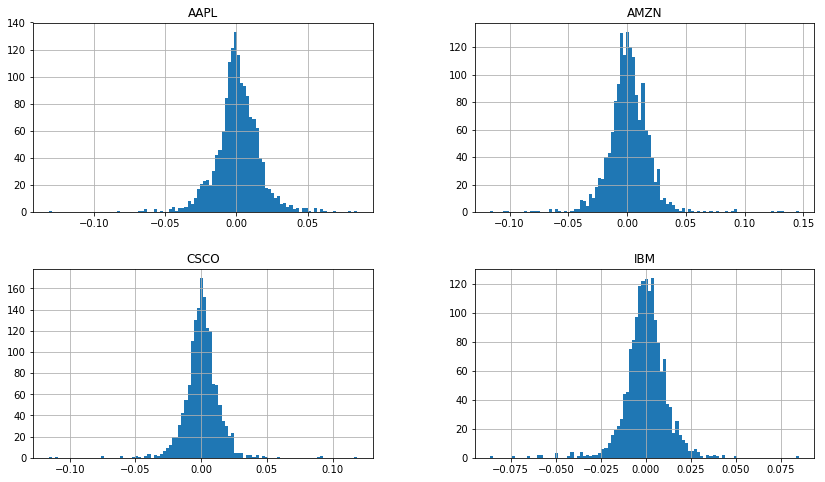

In [116]:
log_ret.hist(bins=100, figsize=(14,8))
plt.show()

In [117]:
log_ret.mean() *  252

AAPL    0.182914
CSCO    0.161780
IBM    -0.005895
AMZN    0.341813
dtype: float64

In [118]:
# pairwise covariance
log_ret.cov()

,AAPL,CSCO,IBM,AMZN
AAPL,0.000248,0.000069,0.000052,0.000078
CSCO,0.000069,0.000191,0.000068,0.000074
IBM,0.000052,0.000068,0.000137,0.000054
AMZN,0.000078,0.000074,0.000054,0.000341


In [119]:
np.random.seed(101)

num_ports = 5000 
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):
    #create random portfolio dostribution weights
    weights = np.array(np.random.random(4))
    #rebalance wights so randoms add to 1 
    weights = weights/np.sum(weights)
    
    #save weights
    all_weights[ind,:] = weights

    #expected portfolio return
    ret_arr[ind] = np.sum((log_ret.mean() * weights)* 252)

    #expected volatility
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

    #Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [122]:
sharpe_arr.max()

1.2809690617734313

In [123]:
sharpe_arr.argmax()

1420

In [124]:
all_weights[1420,:]

array([0.26188068, 0.20759516, 0.00110226, 0.5294219 ])

In [126]:
max_sr_ret = ret_arr[1420]
max_sr_vol = vol_arr[1420]

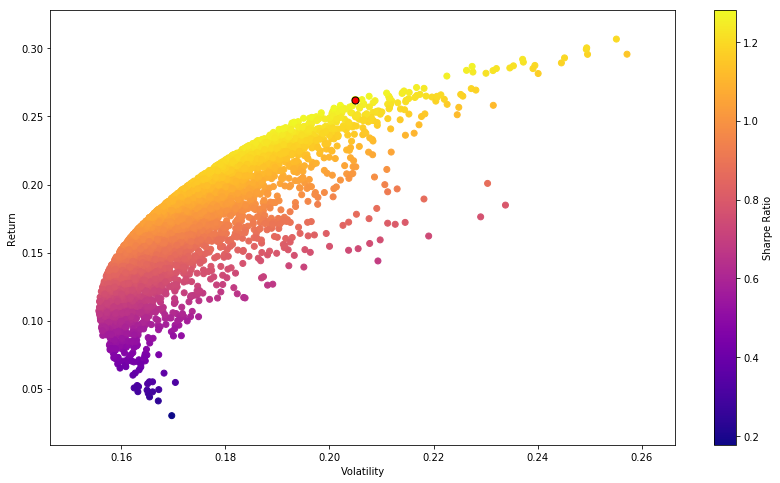

In [127]:
plt.figure(figsize=(14,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return');

plt.scatter(max_sr_vol, max_sr_ret,c='red',s=50,edgecolors='black')

# Markowitz Portfolio Optimization 

In [141]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean()* weights) *252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [142]:
from scipy.optimize import minimize

In [143]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where x is an 1-D array with shape (n,) and `args`
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see here) <op

In [144]:
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2]* -1

In [145]:
def check_sum(weights):
    #return 0 if sum of weights is 1
    return np.sum(weights) -1

In [146]:
cons =({'type':'eq', 'fun': check_sum})

In [147]:
bounds = ((0,1),(0,1),(0,1),(0,1))

In [148]:
init_guess = [0.25,0.25,0.25,0.25]

In [149]:
#sequential leasr squares 
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

In [150]:
opt_results

     fun: -1.2828472171183798
     jac: array([-0.00072451, -0.0004901 ,  0.47258657,  0.00054568])
 message: 'Optimization terminated successfully.'
    nfev: 37
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([2.29846243e-01, 2.44943674e-01, 1.08528637e-16, 5.25210083e-01])

In [151]:
opt_results.x
#allocation

array([2.29846243e-01, 2.44943674e-01, 1.08528637e-16, 5.25210083e-01])

In [152]:
get_ret_vol_sr(opt_results.x)
#peak sharpe we can get is 1.28

array([0.261193  , 0.20360413, 1.28284722])

In [153]:
#efficient frontier optimal porfolio distributions for given risk /return
frontier_y = np.linspace(0,0.3,100)

In [154]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [155]:
frontier_volatility = []
for possible_return in frontier_y:
    cons = ({'type': 'eq', 'fun': check_sum},
           {'type': 'eq', 'fun': lambda w: get_ret_vol_sr(w)[0]-possible_return})
    
    result = minimize(minimize_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    
    frontier_volatility.append(result['fun'])
        

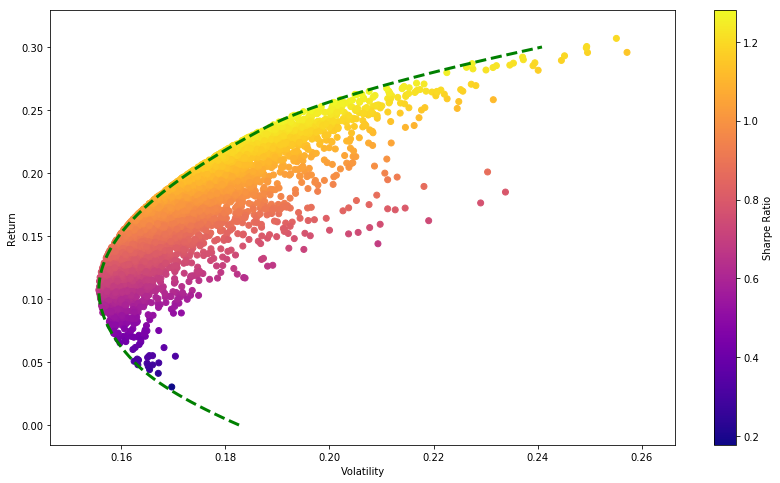

In [159]:
plt.figure(figsize=(14,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.plot(frontier_volatility, frontier_y,'g--', linewidth=3);